In [1]:
import nltk
from nltk.corpus import stopwords, reuters
from nltk import word_tokenize, FreqDist, pos_tag
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.corpus import stopwords, reuters
from string import digits
import pandas as pd
import string
import csv
import re
import matplotlib.pyplot as plt

# Initial Exploration

In [2]:
pf = pd.read_csv('job_details_all_without_duplicate.csv')
pf.head()

,Unnamed: 0,job_link,job_title,company,job_desc
0,0,https://www.indeed.com.sg/rc/clk?jk=ca26664acf...,(Urgent!) IT Support,Target Recruitment a member of WMS Group,Permanent\nLogging and processing support call...
1,1,https://www.indeed.com.sg/company/MegaX/jobs/B...,.Net Developer,Infosys Limited,Job Summary\nAbout Us\nInfosys is a leading pr...
2,2,https://www.indeed.com.sg/pagead/clk?mo=r&ad=-...,.Net Software Engineers,Accenture,Joining Accenture provides you with the opport...
3,3,https://www.indeed.com.sg/rc/clk?jk=b9abd26abf...,2nd / 3rd Line Technical Support Engineer,Singapore,Permanent\nRoles & Responsibilities\nOn a day-...
4,4,https://www.indeed.com.sg/pagead/clk?mo=r&ad=-...,AMOS Support Specialist,Singapore,Roles & Responsibilities\nLufthansa Systems is...


In [6]:
pf.iloc[:,1:5].describe()

,job_link,job_title,company,job_desc
count,924,924,924,924
unique,924,809,530,917
top,https://www.indeed.com.sg/rc/clk?jk=5efeafa191...,Software Engineer,Singapore,Job Summary\nKodak is looking for a high energ...
freq,1,25,57,2


Break the dataframe into 3 separate lists

In [7]:
company=pf['company'].tolist()
title=pf['job_title'].tolist()
desc=pf['job_desc'].tolist()

In [8]:
stop = stopwords.words('english')
custom_stop = ['job','work','type','time','full','singapore','location','requirements','’','month','year','responsibility','role','skill','working','experience']
stop.extend(custom_stop)
substitute = {"undergraduate": "bachelor", 
              "undergrad": "bachelor", 
              "bs": "bachelor",
              "graduate": "bachelor",
              "postgraduate": "master",
              "postgrad": "master",
              "ms": "master",
              "doctor": "phd",
              "doctoral": "phd"}
WNlemma = nltk.WordNetLemmatizer()

In [9]:
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [10]:
def pre_process(_list):
    job_list=[]
    for item in _list:
        word = item.lower()
        word = word.replace('\n', ' ')
        word = replace(word, substitute)
        for letter in word:
            if letter not in string.punctuation:
                word = word
            else:
                word = word.replace(letter, " ")
        word = ''.join(word)
        remove_digits = str.maketrans('', '', digits)
        word = word.translate(remove_digits)
        tokens = word_tokenize(word)
        tokens = [WNlemma.lemmatize(t) for t in tokens]
        tokens_nostop=[ t for t in tokens if t not in stop]
        job_list.append(tokens_nostop)
    return job_list

In [11]:
job_company=[]
for i in company:
    comp=i.lower()
    for t in comp:
        if t not in string.punctuation:
            comp = comp.replace(t, t)
        else:
            comp = comp.replace(t, " ")
    comp=''.join(comp)
    job_company.append(comp)

In [12]:
job_title = pre_process(title)
job_desc = pre_process(desc)

Company that posted the most jobs

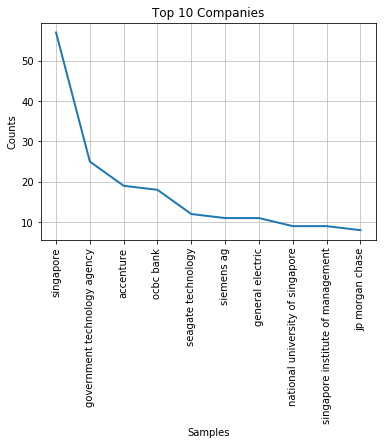

In [26]:
fd = FreqDist(job_company)
fd.most_common(10)
fd.plot(10,title= "Top 10 Companies")

Most frequenly posted jobs

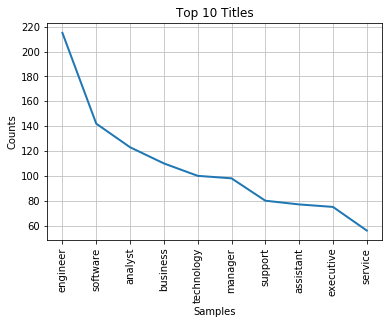

In [27]:
title_flat = [ c for l in job_title for c in l ]
fd_title = FreqDist(title_flat)
fd_title.most_common(10)
fd_title.plot(10,title= "Top 10 Titles")

Most commonly occuring keywords in the postings
Some words occurs too often so meaning is obscure, hence need to proceed with collation

In [28]:
desc_flat = [ c for l in job_desc for c in l ]
fd_desc = FreqDist(desc_flat)
fd_desc.most_common(20)
#fd_desc.plot(10)

[('business', 1998),
 ('technology', 1842),
 ('team', 1594),
 ('project', 1416),
 ('management', 1361),
 ('support', 1341),
 ('requirement', 1278),
 ('development', 1272),
 ('service', 1222),
 ('customer', 1123),
 ('solution', 1014),
 ('software', 999),
 ('knowledge', 956),
 ('design', 946),
 ('application', 944),
 ('data', 944),
 ('technical', 912),
 ('strong', 891),
 ('ability', 890),
 ('product', 887)]

Create word frequency list for later use

In [29]:
# calc word frequency in job_description
wordFreq = []    
for k,v in fd_desc.items():
    freq = []
    for i in k:
        k = "".join(k)
    freq.append(k)
    freq.append(v)
    wordFreq.append(freq)

# Mostly used adjectives

Extract all the adjectives in the words after POS tagging. The adjectives may be used to describe the desired candidate.

In [42]:
# get top adjectives
def top_adjectives(words,num):
    adj_list = []
    for word in words:
        i=pos_tag(word_tokenize(word[0]))
        for t in i:
            if t[1] == 'JJ':
                adj_list.append(word)
    df_adj_list = pd.DataFrame(adj_list)
    sorted_adj_list = df_adj_list.sort_values(df_adj_list.columns[1],ascending=False )
    top_adj = sorted_adj_list[:num]
    plt.bar(top_adj[0],top_adj[1])
    plt.xticks(top_adj[0], rotation='50',)

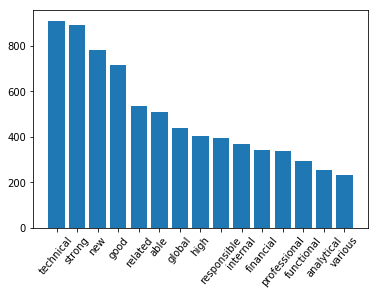

In [45]:
top_adjectives(wordFreq,15)

# Skills and Education

Using domain knowledge to create a dictionary for skills and education level

In [46]:
# create dictionary for skills and education based on domain knowledge
skills = ['r','python','itil','adobe','net','oracle','sql','microsoft','jira','agile',
          'scrum','linux','basic','shell','xml','http','html','javascript','php','qlikview',
          'qlik','java','ruby','tableau','cpp','cloud','oop','database','perl','c','css',
          'scala','swift','typescript']
education = ['diploma','polytechnic','bachelor','master','degree','phd','postdoc']

In [48]:
def top_freq(full, subset, num):
    sub_list=[]
    for word in full:
        _list = []
        if word[0] in subset:
            _list.append(word[0])
            _list.append(word[1])
            sub_list.append(_list)
    df_sub=pd.DataFrame(sub_list)
    sorted_sub=df_sub.sort_values(df_sub.columns[1],ascending=False )
    top_sub = sorted_sub[:num]
    plt.bar(top_sub[0],top_sub[1])
    plt.xticks(top_sub[0], top_sub[0], rotation='50')

Most frequently mentioned technical skills & education level

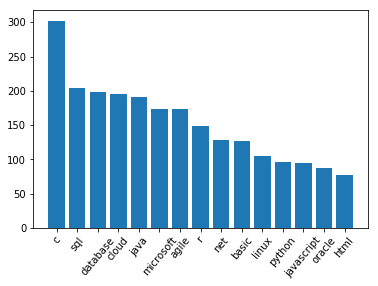

In [53]:
top_freq(wordFreq, skills, 15)

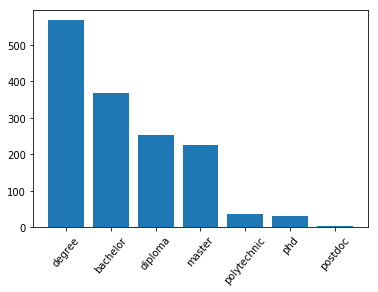

In [50]:
top_freq(wordFreq, education, 10)

# Common Title and Words

In [61]:
filter_stops = lambda w: len(w) < 3 or w.isdigit()

In [75]:
def top_bigram(flat,num, win):
    bcf = BigramCollocationFinder.from_words(flat, window_size = win)
    bcf.apply_word_filter(filter_stops)
    bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
    ngramList = []
    for k,v in bcf.ngram_fd.items():
        ngram = []
        value = k[0]+" "+k[1]
        ngram.append(value)
        ngram.append(v)
        ngramList.append(ngram)
    df_ngram=pd.DataFrame(ngramList)
    sorted_ngram=df_ngram.sort_values(df_ngram.columns[1],ascending=False)
    top_ngram=sorted_ngram[:num]
    plt.bar(top_ngram[0],top_ngram[1])
    plt.xticks(top_ngram[0], top_ngram[0], rotation='90')

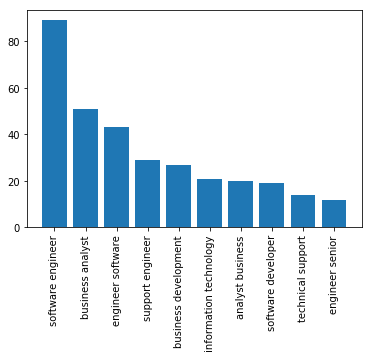

In [76]:
top_bigram(title_flat,10,2)

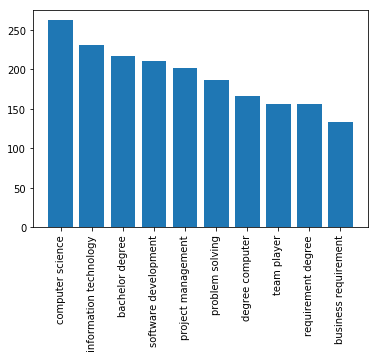

In [80]:
# words commonly occur together in decription
top_bigram(desc_flat,10,3)